# **<h3 align="center">Machine Learning - Project</h3>**
## **<h3 align="center">2. Preprocessing & Cleaning</h3>**
### **<h3 align="center">Group 30 - Project</h3>**


### Group Members
| Name              | Email                        | Student ID |
|-------------------|------------------------------|------------|
| Alexandra Pinto   | 20211599@novaims.unl.pt      | 20211599   |
| Gonçalo Peres     | 20211625@novaims.unl.pt      | 20211625   |
| Leonor Mira       | 20240658@novaims.unl.pt      | 20240658   |
| Miguel Natário    | 20240498@novaims.unl.pt      | 20240498   |
| Nuno Bernardino   | 20211546@novaims.unl.pt      | 20211546   |

---

### **2. Preprocessing & Cleaning Notebook**
**Description:**
This notebook processes the dataset from the Imports & Data Exploration notebook, addressing inconsistencies, handling missing values, and preparing the dataset for feature engineering. Key steps include:
- **Data Splitting:** Divide the dataset into training, validation, and test sets.
- **Handling Missing Values:** Impute missing values based on conditional means, modes, or specific handling strategies for different features.
- **Outlier Removal:** Identify and handle extreme values systematically to improve data consistency.
- **Encoding Categorical Variables:** Use encoding techniques (e.g., ordinal, one-hot, or frequency encoding) to transform categorical features into a suitable format for modeling.
- **Output:** Save the **preprocessed dataset** in a structured format (e.g., CSV or Pickle) for feature engineering.

This notebook ensures that the data is clean, consistent, and ready for further feature engineering.

---

<a id = "toc"></a>

## Table of Contents
* [1. Import the Libraries](#chapter1)
* [2. Import the Datasets](#chapter2)       
* [3. Train Test Split](#chapter3)
* [4. Preprocessing the Data](#chapter4)
    * [4.1. Outliers](#section_4_1) 
    * [4.2. Missing Values](#section_4_2) 
        * [4.2.1. Handling High Zero Columns](#sub_section_4_2_1)
        * [4.2.2. Handling Missing Values in IME-4 Count](#sub_section_4_2_2)
        * [4.2.3. Handling Missing Values in C-3 Date, C-2 Date, and First Hearing Date](#sub_section_4_2_3)
        * [4.2.4. Handling Missing Values in Industry Code](#sub_section_4_2_4) 
        * [4.2.5. Handling Missing Values in Average Weekly Wage](#sub_section_4_2_5)
        * [4.2.6. Handling Missing Values in Zip Code](#sub_section_4_2_6)
        * [4.2.7. Handling Missing Values in Birth Year](#sub_section_4_2_7)
        * [4.2.8. Handling Missing Values in Injury Codes](#sub_section_4_2_8) 
        * [4.2.9. Remaining Missing Values](#sub_section_4_2_9) 

# 1. Import the Libraries 📚<a class="anchor" id="chapter1"></a>

[Back to ToC](#toc)<br>

In this section we will imported the needed libraries for this notebook.

In [ ]:
# --- Standard Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import zipfile
import re
import os


# --- Scikit-Learn Modules for Data Partitioning and Preprocessing ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# --- Warnings ---
import warnings
warnings.filterwarnings('ignore')

#Import functions from utils
from utils import check_code_description_combinations

# 2. Load and Prepare Datasets 📁<a class="anchor" id="chapter2"></a>
[Back to ToC](#toc)<br>

Now, we will load the dataset prepared in **Notebook 1: Imports & Data Exploration**, where we addressed key inconsistencies such as missing values, invalid codes, and other data quality issues. This cleaned dataset serves as the foundation for the preprocessing steps in this notebook.

In [1]:
df_train = pd.read_csv(r'../processed_datasets/cleaned_train_dataset.csv', index_col='Claim Identifier')
df_test = pd.read_csv(r'../processed_datasets/cleaned_test_dataset.csv',index_col='Claim Identifier')

NameError: name 'pd' is not defined

# 3. Train Test Split <a class="anchor" id="chapter3"></a>
[Back to ToC](#toc)<br>

Splitting the dataset into training and test sets is a crucial step in building a machine learning model. In this project, we perform the train-test split after correcting inconsistencies but before data preprocessing, such as handling missing values, outlier treatment, and feature scaling. This sequence helps in maintaining the integrity of our data and ensures that the model is trained and evaluated fairly.

The train-test split is performed after fixing inconsistencies but before preprocessing to ensure that we do not inadvertently introduce information from the test set into the training set. This allows us to maintain the integrity of our model evaluation and helps ensure that the results obtained during model evaluation are unbiased and reflect the model’s performance on truly unseen data.

In [ ]:
X= df_train.drop('Claim Injury Type',axis=1)
y= df_train['Claim Injury Type']

# Encode o target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, 
                                                  random_state = 42, 
                                                  stratify = y, 
                                                  shuffle = True)

# 4. Preprocessing the Dataset ⚒️ <a class="anchor" id="chapter4"></a>
[Back to ToC](#toc)<br>


In this chapter, we will perform the basic steps to get to know our dataset.


## 4.1. Outliers <a class="anchor" id="section_4_1"></a>
[Back to 4. Preprocessing the Dataset](#chapter4)<br>


The columns below are those that may have outliers in our dataset:

- **Age at Injury** – The age of the person at the time of the accident.
- **Average Weekly Wage** – Average weekly wage.
- **Number of Dependents** – Number of dependents (may have outliers in cases with a high number of dependents).
- **Accident Year** – Year of the accident.
- **WCIO Cause of Injury Code, WCIO Nature of Injury Code, WCIO Part Of Body Code** – Although these are codes, if they have continuously high numerical values, they may contain outliers.

In [ ]:
numerical_vars = ['Age at Injury', 'Average Weekly Wage', 'Number of Dependents', 'Accident Year']
categorical_vars = ['WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']

In [ ]:
# Analyze numerical variables for potential outliers using IQR
def analyze_numerical_outliers(df, columns):
    numerical_outliers = {}
    for column in columns:
        Q1 = df[column].quantile(0.25)  # First quartile (25%)
        Q3 = df[column].quantile(0.75)  # Third quartile (75%)
        IQR = Q3 - Q1                   # Interquartile range
        lower_bound = Q1 - 1.5 * IQR    # Lower bound for outliers
        upper_bound = Q3 + 1.5 * IQR    # Upper bound for outliers
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outliers_count = outliers.shape[0]
        numerical_outliers[column] = outliers_count
    return numerical_outliers

# Run the analysis
numerical_outliers_summary = analyze_numerical_outliers(X_train, numerical_vars)

# Display the summary
print("Number of potential outliers in numerical variables:")
for column, count in numerical_outliers_summary.items():
    print(f"{column}: {count} outliers")

Number of potential outliers in numerical variables:
Age at Injury: 0 outliers
Average Weekly Wage: 15526 outliers
Number of Dependents: 0 outliers
Accident Year: 3414 outliers


Lets use some graphs to check the values in a boxplot

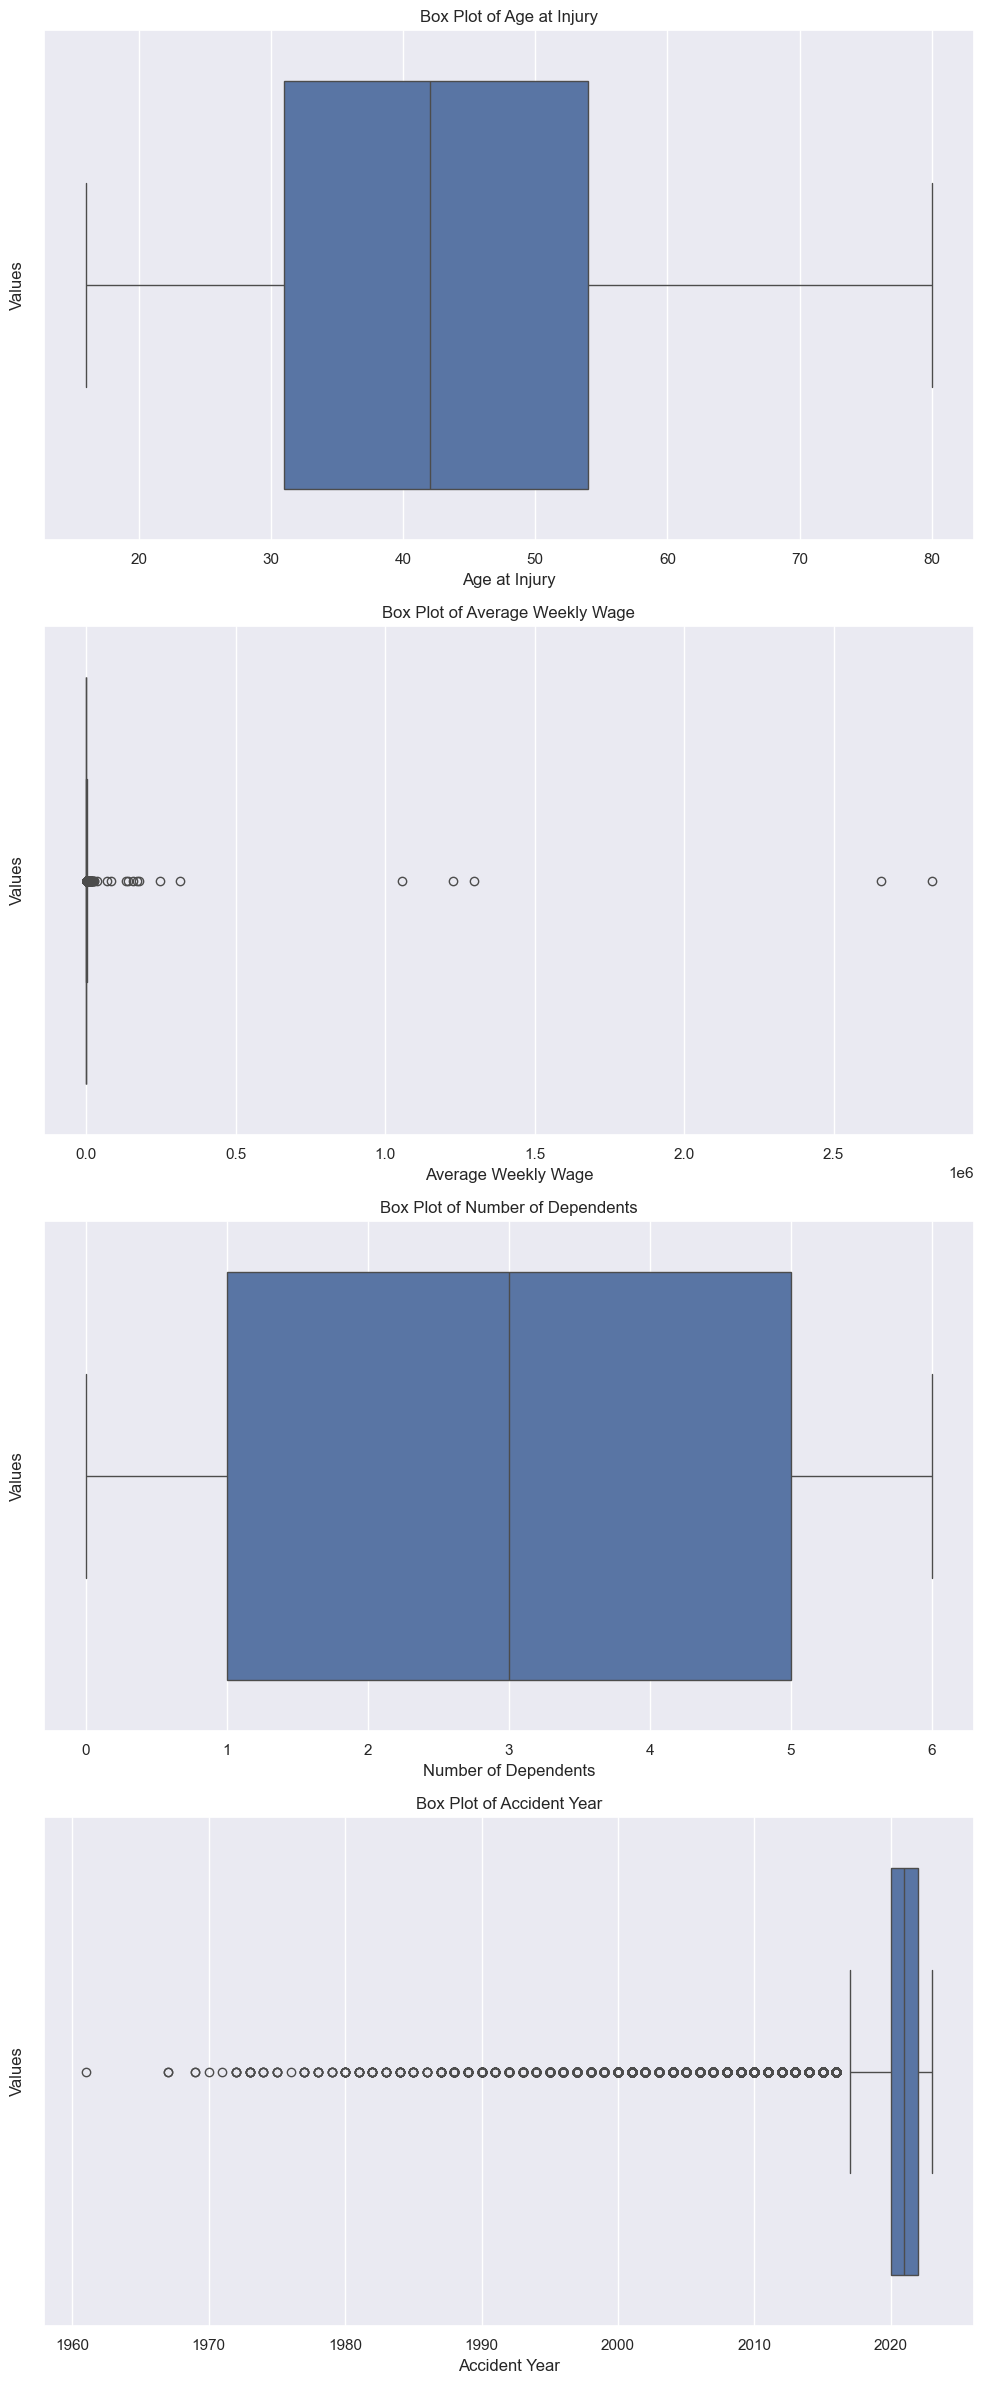

In [ ]:
plt.figure(figsize=(10, 6 * len(numerical_vars)))

# Loop through each numeric column and plot a separate box plot
for i, col in enumerate(numerical_vars, 1):
    plt.subplot(len(numerical_vars), 1, i)
    sns.boxplot(x=X_train[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Values')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Average Weekly Wage

The majority of the values for the Average Weekly Wage column appear to be zero. This suggests that our initial analysis of outliers may not be valid, as most of these values seem to be incorrect or invalid. We will address this issue in detail later in the notebook.

Age at Injury

Although no significant outliers were identified by the function output, this dataset focuses on workplace accidents, and some recorded ages seem unrealistic. Let's verify if these values exist, and if they do, remove them accordingly.

In [ ]:
# Display unique values in the "Age at Injury" column
unique_values = X_train['Age at Injury'].unique()

# Check the value counts of the "Age at Injury" column
age_counts = X_train['Age at Injury'].value_counts()

# Print the unique values
print("Unique values in 'Age at Injury':", unique_values)
print("Number of each value in 'Number of Dependents:", age_counts)

Unique values in 'Age at Injury': [24. 36. 41. 59. 58. 56. 54. 31. nan 44. 23. 49. 57. 42. 37. 63. 25. 76.
 50. 46. 21. 33. 34. 48. 67. 32. 62. 43. 27. 47. 29. 51. 64. 61. 22. 35.
 60. 38. 55. 52. 53. 28. 40. 65. 30. 70. 66. 45. 19. 74. 72. 69. 39. 20.
 18. 26. 73. 79. 71. 68. 75. 77. 17. 78. 16. 80.]
Number of each value in 'Number of Dependents: Age at Injury
32.0    9095
30.0    8889
31.0    8826
33.0    8683
29.0    8528
        ... 
77.0     246
78.0     225
16.0     194
79.0     179
80.0     151
Name: count, Length: 65, dtype: int64


In New York, the standard retirement age for public employees varies based on their membership tier and years of credited service:

Full Retirement Benefits: Generally available at age 62. However, members with at least 30 years of credited service can retire as early as age 55 without a reduction in benefits. 

Early Retirement with Reduced Benefits: Members with fewer than 30 years of service may retire between ages 55 and 62, but their benefits will be reduced based on their exact age at retirement.

Having this information in mind, we decided on the following bounds:

Lower Bound (Minimum Working Age):
The minimum legal working age in New York is typically 16 years, so values below this are logically invalid for most worker datasets and should be removed.

Upper Bound (Retirement Age):
The normal retirement age in New York is 62–65 years, with many workers retiring by age 70. However, some exceptions exist (e.g., individuals working part-time or in specialized fields beyond 70). A reasonable upper cutoff could be 75.

In [ ]:
# Identify rows to drop based on age outliers
#rows_to_drop = X_train[(X_train['Age at Injury'] < 16) | (X_train['Age at Injury'] > 75)].index

# Drop the rows
#X_train = X_train.drop(rows_to_drop)

# Verify the range after cleaning
#print("Age range after cleaning:", X_train['Age at Injury'].min(), "-", X_train['Age at Injury'].max())

The "Age at Injury" column has now been properly addressed.

Number of dependents

The data in this column seems accurate, but we will double-check to ensure everything is correct.

In [ ]:
# Display unique values in the "Number of dependents" column
unique_values = X_train['Number of Dependents'].unique()

# Check the value counts of the "Number of dependents" column
dep_counts = X_train['Number of Dependents'].value_counts()

# Print the unique values
print("Unique values in 'Number of Dependents':", unique_values)
print("Number of each value in 'Number of Dependents':", dep_counts)

Unique values in 'Number of Dependents': [3. 2. 1. 5. 0. 4. 6.]
Number of each value in 'Number of Dependents': Number of Dependents
6.0    57851
3.0    57655
4.0    57422
5.0    57377
1.0    57375
0.0    57117
2.0    57021
Name: count, dtype: int64


No outliers were detected in our analysis.

Accident Year

While no outliers were initially detected, we will re-examine the data to confirm this and ensure the results are accurate.

In [ ]:
# Display unique values in the "Accident Year" column
unique_values = X_train['Accident Year'].unique()

# Check the value counts of the "Accident Year" column
year_counts = X_train['Accident Year'].value_counts()

# Print the unique values
print("Unique values in 'Accident Year':", unique_values)
print("Number of each value in 'Accident Year:", year_counts)

Unique values in 'Accident Year': [2020. 2022. 2021.   nan 2019. 1999. 2018. 2023. 1997. 2001. 2007. 2017.
 2016. 2011. 2000. 2010. 1993. 2015. 2009. 2013. 1990. 2014. 2004. 1989.
 2003. 2006. 2002. 1998. 1985. 1996. 1995. 2005. 2012. 2008. 1976. 1991.
 1988. 1992. 1984. 1980. 1983. 1973. 1971. 1982. 1994. 1974. 1986. 1978.
 1977. 1987. 1975. 1969. 1967. 1970. 1979. 1961. 1981. 1972.]
Number of each value in 'Accident Year: Accident Year
2021.0    132808
2022.0    130189
2020.0    121577
2019.0     10052
2018.0       845
2001.0       357
2017.0       305
2016.0       240
2013.0       212
2015.0       196
2011.0       195
2014.0       182
2012.0       180
2010.0       161
2008.0       140
2009.0       126
2004.0       119
2006.0       105
2000.0       104
2007.0       103
2005.0       100
2002.0        95
2003.0        92
1997.0        84
1998.0        77
1999.0        74
1996.0        71
1995.0        58
1994.0        42
2023.0        41
1992.0        40
1988.0        34
1990.0        

The vast majority of  Accident Year values are concentrated between 2020 and 2022. Values outside this range seem to represent very few occurrences, potentially making them outliers.

We decided on the following bounds:

Lower Bound: Remove values earlier than 2018 because they represent significantly fewer occurrences compared to the dominant years (2020–2022). This will remove older accident years that are unlikely to be relevant to your analysis.

Upper Bound: Since the data appears to include 2022 as the latest year, anything beyond that (e.g., accidental entries) should also be removed.

In [ ]:
# Identify rows to drop based on Accident Year outliers
#rows_to_drop = X_train[(X_train['Accident Year'] < 2018) | (X_train['Accident Year'] > 2022)].index

# Drop the rows
#X_train = X_train.drop(rows_to_drop)

# Verify the range after cleaning
#print("Age range after cleaning:", X_train['Accident Year'].min(), "-", X_train['Accident Year'].max())

The "Accident Year" column has now been properly addressed.

In [ ]:
def clean_data(X_train, df_y_train, age_range=(16, 75), year_range=(2018, 2022)):
    """
    Cleans the data by removing rows based on Age at Injury and Accident Year outliers.

    Parameters:
        X_train (pd.DataFrame): The features DataFrame.
        df_y_train (pd.DataFrame): The labels DataFrame.
        age_range (tuple): The acceptable range for 'Age at Injury' (min, max).
        year_range (tuple): The acceptable range for 'Accident Year' (min, max).

    Returns:
        pd.DataFrame: Cleaned X_train DataFrame.
        pd.DataFrame: Cleaned df_y_train DataFrame.
    """
    # Ensure indices of df_y_train align with X_train
    df_y_train.index = X_train.index

    # Identify rows to drop based on Age at Injury and Accident Year
    rows_to_drop = X_train[
        (X_train['Age at Injury'] < age_range[0]) | 
        (X_train['Age at Injury'] > age_range[1]) |
        (X_train['Accident Year'] < year_range[0]) |
        (X_train['Accident Year'] > year_range[1])
    ].index

    # Drop rows in both DataFrames
    X_train_cleaned = X_train.drop(rows_to_drop)
    df_y_train_cleaned = df_y_train.drop(rows_to_drop)

    # Verify the ranges after cleaning
    print("Age range after cleaning:", X_train_cleaned['Age at Injury'].min(), "-", X_train_cleaned['Age at Injury'].max())
    print("Accident Year range after cleaning:", X_train_cleaned['Accident Year'].min(), "-", X_train_cleaned['Accident Year'].max())

    return X_train_cleaned, df_y_train_cleaned


In [ ]:
# Clean the data
X_train_cleaned, df_y_train_cleaned = clean_data(X_train, df_y_train)

# Display the first few rows of the cleaned DataFrames
print("\nCleaned X_train:")
print(X_train_cleaned.head())

print("\nCleaned df_y_train:")
print(df_y_train_cleaned.head())


Age range after cleaning: 16.0 - 75.0
Accident Year range after cleaning: 2018.0 - 2022.0

Cleaned X_train:
                 Accident Date  Age at Injury Assembly Date  \
Claim Identifier                                              
5479022             2020-05-05           24.0    2020-05-08   
6023025             2022-05-10           36.0    2022-06-25   
5851908             2021-05-19           41.0    2021-11-08   
5913931             2022-02-03           59.0    2022-02-04   
5845976             2021-09-21           58.0    2021-10-29   

                  Attorney/Representative  Average Weekly Wage  Birth Year  \
Claim Identifier                                                             
5479022                               0.0                 0.00      1996.0   
6023025                               1.0              1097.00      1986.0   
5851908                               1.0               623.35      1980.0   
5913931                               1.0              1042.

In [ ]:
# Using to_numpy() method
y_train = df_y_train.to_numpy()
y_train

array([[1],
       [3],
       [3],
       ...,
       [4],
       [1],
       [1]])

WCIO Variables

The analysis of numerical variables is complete. Now, let’s move on to examining the categorical variables.

In [ ]:
# Analyze categorical variables for rare categories
def analyze_categorical_outliers(df, columns):
    categorical_outliers = {}
    for column in columns:
        value_counts = df[column].value_counts(normalize=True)  # Get frequency of each category
        rare_categories = value_counts[value_counts < 0.01]     # Categories with less than 1% frequency
        categorical_outliers[column] = rare_categories
    return categorical_outliers

# Run the analysis
categorical_outliers_summary = analyze_categorical_outliers(X_train, categorical_vars)

# Display the summary
for column, rare_cats in categorical_outliers_summary.items():
    print(f"\nRare categories in {column} (less than 1% of data):")
    print(rare_cats)


Rare categories in WCIO Cause of Injury Code (less than 1% of data):
WCIO Cause of Injury Code
87.0    0.009080
50.0    0.008865
90.0    0.008491
30.0    0.008235
58.0    0.008056
98.0    0.007790
70.0    0.007140
10.0    0.007015
77.0    0.006652
80.0    0.005915
82.0    0.005833
18.0    0.005831
76.0    0.005784
59.0    0.005270
2.0     0.005140
66.0    0.005050
9.0     0.004431
15.0    0.004336
5.0     0.003592
1.0     0.003316
28.0    0.003239
46.0    0.002576
54.0    0.002515
52.0    0.002366
78.0    0.002310
69.0    0.002039
6.0     0.001845
94.0    0.001297
84.0    0.001261
48.0    0.001118
20.0    0.001011
65.0    0.000975
4.0     0.000826
3.0     0.000806
88.0    0.000760
61.0    0.000709
41.0    0.000519
95.0    0.000466
11.0    0.000363
86.0    0.000276
67.0    0.000243
96.0    0.000233
93.0    0.000182
7.0     0.000133
91.0    0.000092
40.0    0.000084
14.0    0.000084
8.0     0.000069
47.0    0.000023
Name: proportion, dtype: float64

Rare categories in WCIO Nature of Inj

Despite having several codes that are rarely used (less than 1% of the dataset), we decided to retain all codes for now. Since the dataset includes rare cases that need to be predicted, this approach ensures that our model remains as accurate as possible.

## 5.2. Missing Values <a class="anchor" id="section_5_2"></a>

We may also have missing values that are incorrectly set to zero. Therefore, we will use `.eq(0)` to identify if there are any columns with zeros that are not supposed to have them.


In [ ]:
# Count the number of zeros in each column
X_train.eq(0).sum()

Accident Date                      0
Age at Injury                      0
Assembly Date                      0
Attorney/Representative       274690
Average Weekly Wage           234703
Birth Year                         0
C-2 Date                           0
C-3 Date                           0
Carrier Name                       0
Carrier Type                       0
County of Injury                   0
COVID-19 Indicator            382407
District Name                      0
First Hearing Date                 0
Gender                             0
IME-4 Count                        0
Industry Code                      0
Medical Fee Region                 0
WCIO Cause of Injury Code          0
WCIO Nature of Injury Code         0
WCIO Part Of Body Code             0
Zip Code                           0
Agreement Reached             383137
Number of Dependents           57117
Accident Year                      0
Category Combination               0
dtype: int64

In [ ]:
X_train.shape

(401818, 26)

In [ ]:
X_val.shape

(172208, 26)

In this section, we identify columns with a high number of zero values, which might indicate potential missing values represented by zero instead of NaN. This helps us to locate inconsistencies or placeholders that we need to address during data preprocessing.

Key observations from the output:

__`Average Weekly Wage`__: **234703** entries have zeros, indicating potential data issues.

__`COVID-19 Indicator`__: **382530** entries are zeros, which may represent cases without a COVID-related claim.

__`Agreement Reached`__: **383137** entries have zeros, which could indicate missing or null agreements.

__`Number of Dependents`__: **57117** entries with zeroes might indicate missing values in this column.

This analysis allows us to consider the necessity of replacing or imputing these zero values during the data preprocessing steps, ensuring they do not interfere with model training and evaluation.

### 5.2.1. Handling High Zero Columns <a class="anchor" id="sub_section_5_2_1"></a>

In [ ]:
# Set the threshold for zero values (e.g., more than 20% zeros)
threshold = 0.2

# Calculate the percentage of zeros for each column
zero_percentage = X_train.eq(0).mean()

# Filter columns that have more than the threshold of zero values
high_zero_columns = zero_percentage[zero_percentage > threshold]

# Display the columns with their zero percentage
print(high_zero_columns*100)

Attorney/Representative    68.361796
Average Weekly Wage        58.410275
COVID-19 Indicator         95.169206
Agreement Reached          95.350880
dtype: float64


We set a threshold to identify columns with a high proportion of zero values (more than 20%). This analysis helps us determine if any columns contain zeros that might represent missing data instead of actual values.

The columns that have more than 20% of zero values are:
- **Attorney/Representative**: 68.36% zeros
- **Average Weekly Wage**: 58.41% zeros
- **COVID-19 Indicator**: 95.20% zeros
- **Agreement Reached**: 95.35% zeros

We found that **Average Weekly Wage** contains an unexpectedly high number of zeros, which is likely incorrect for this dataset. Since every employee should have a weekly wage, these zeros should be treated as missing values. Therefore, we will replace the zeros in the **Average Weekly Wage** column with `NaN`.


We found that only one column, Average Weekly Wage, contains an unexpectedly high number of zeros. Since this dataset is related to work insurance, every employee must have a weekly wage, meaning these zeros are likely incorrect and should be treated as missing values. Therefore, we will replace the zeros in the Average Weekly Wage column with NaN.

In [ ]:
# Replace zeros in 'Average Weekly Wage' with NaN in the train, validation, and test sets
X_train['Average Weekly Wage'] = X_train['Average Weekly Wage'].replace(0, np.nan)
X_val['Average Weekly Wage'] = X_val['Average Weekly Wage'].replace(0, np.nan)
df_test['Average Weekly Wage'] = df_test['Average Weekly Wage'].replace(0, np.nan)

### Identifying Remaining Missing Values

After treating zeros as missing values in the **Average Weekly Wage** column, we will now examine the dataset for any remaining `NaN` values. This step ensures that all missing data points are identified, enabling us to address them systematically.

The table below displays the count of missing values (NaN) for each column in the dataset. Some columns, such as **First Hearing Date** and **IME-4 Count**, contain a significant number of missing values, which may require further investigation and treatment.

In [ ]:
# Display count of NaN values for each column in the training dataset
X_train.isnull().sum()

Accident Date                   2587
Age at Injury                  40880
Assembly Date                   1022
Attorney/Representative            0
Average Weekly Wage           254769
Birth Year                     38491
C-2 Date                       10903
C-3 Date                      271096
Carrier Name                       0
Carrier Type                       0
County of Injury                   0
COVID-19 Indicator                 0
District Name                      0
First Hearing Date            296368
Gender                             0
IME-4 Count                   308855
Industry Code                   6969
Medical Fee Region                 0
WCIO Cause of Injury Code      10945
WCIO Nature of Injury Code     10956
WCIO Part Of Body Code         11919
Zip Code                           0
Agreement Reached                  0
Number of Dependents               0
Accident Year                   2587
Category Combination               0
dtype: int64

**Columns with High Percentage of Missing Values**

In [ ]:
# Set the threshold for missing values (e.g., more than 30% missing)
threshold = 0.2

# Calculate the percentage of missing values for each column
missing_percentage = X_train.isnull().mean()

# Filter columns that have more than the threshold of missing values
high_missing_columns = missing_percentage[missing_percentage > threshold]

# Display the columns with their missing percentage
print(high_missing_columns*100)

Average Weekly Wage    63.404078
C-3 Date               67.467361
First Hearing Date     73.756775
IME-4 Count            76.864401
dtype: float64


Using a threshold of 20%, we identified columns with a high percentage of missing values. Columns such as **First Hearing Date** and **IME-4 Count** have more than 70% missing data, which makes them candidates for potential feature engineering or alternative handling.

In particular:
- **First Hearing Date**: Given its high missing rate, this feature could potentially be transformed into a binary indicator, where 0 indicates missing and 1 indicates available data. This approach allows us to retain any signal that might be present in the presence or absence of this information.

Let's explore more about the rest of missing values.

### 5.2.2. Handling Missing Values in `IME-4 Count` <a class="anchor" id="sub_section_5_2_2"></a>

The `IME-4 Count` feature represents the number of independent medical audit examinations. A missing value (`NaN`) in this column likely indicates that no audits were conducted for a specific case. Therefore, we have decided to replace all `NaN` values with 0 to indicate that there was no audit.



In [ ]:
# Display unique values in 'IME-4 Count' to understand the range
X_train['IME-4 Count'].unique()

array([nan,  4.,  2.,  1., 19.,  8.,  5.,  6.,  3., 10., 11.,  7.,  9.,
       21., 15., 22., 14., 17., 18., 12., 13., 16., 23., 24., 20., 27.,
       31., 25., 26., 28., 37., 32., 36., 29., 73., 39., 30., 35., 48.,
       47., 34.])

As IME-4 represents the number of independent medical audicts examination we decided to convert nan to 0 meaning that there wasn't any.

In [ ]:
# Replace NaN values in 'IME-4 Count' with 0 in the training, validation, and test sets
X_train['IME-4 Count'].fillna(0, inplace=True)
X_val['IME-4 Count'].fillna(0, inplace=True)
df_test['IME-4 Count'].fillna(0, inplace=True)

# Confirm replacement by displaying unique values again
X_train['IME-4 Count'].unique()

array([ 0.,  4.,  2.,  1., 19.,  8.,  5.,  6.,  3., 10., 11.,  7.,  9.,
       21., 15., 22., 14., 17., 18., 12., 13., 16., 23., 24., 20., 27.,
       31., 25., 26., 28., 37., 32., 36., 29., 73., 39., 30., 35., 48.,
       47., 34.])

### 5.2.3. Handling Missing Values in `C-3 Date`, `C-2 Date`, and `First Hearing Date` <a class="anchor" id="sub_section_5_2_3"></a>


After reviewing the documentation from data.gov.ny, it was discovered that missing values (NaN) in the C-3 Date, C-2 Date, and First Hearing Date columns have a specific meaning: "blanks indicate no form received."

Given this clarification, we will no longer treat these as missing values. Instead:

Missing values (NaN) will be replaced with 0 to indicate "No form received."
This adjustment ensures that the data accurately reflects the provided context and avoids misinterpretation of missing values as a lack of data.


In [ ]:
# Replace NaN values in specified columns with 0 to indicate "No form received"
columns_to_update = ['C-3 Date', 'C-2 Date', 'First Hearing Date']
X_train[columns_to_update] = X_train[columns_to_update].fillna(0)
X_val[columns_to_update] = X_val[columns_to_update].fillna(0)
df_test[columns_to_update] = df_test[columns_to_update].fillna(0)

> #### Defining a threshold for missing values


In [ ]:
# Set the threshold for missing values - in this case, 30% of the columns
threshold = X_train.shape[1] * 0.30

# Count the number of NaNs in each row
nan_counts_per_row = X_train.isna().sum(axis=1)

# Find rows with more than 30% NaNs
rows_with_high_nan = nan_counts_per_row > threshold

# Calculate the percentage of rows with more than 30% NaNs
percentage_rows_with_high_nan = (rows_with_high_nan.sum() / X_train.shape[0]) * 100

print(f"Percentage of rows with more than 30% missing values: {percentage_rows_with_high_nan:.4f}%")

Percentage of rows with more than 30% missing values: 0.1648%


In [ ]:
y_train.shape

(401818, 1)

In [ ]:
X_train.shape

(401818, 26)

In [ ]:
# Step 1: Identify rows with more than 30% NaNs in X_train
threshold = int(X_train.shape[1] * 0.3)  # Calculate the threshold for 30% NaNs
rows_with_high_nan = X_train.isnull().sum(axis=1) > threshold  # Rows with more than 30% NaNs

# Step 2: Create the boolean mask to keep rows
rows_to_keep = ~rows_with_high_nan  # Invert the mask to keep rows with <= 30% NaNs

# Step 3: Apply the boolean mask to X_train and y_train
X_train = X_train[rows_to_keep].copy()
y_train = y_train[rows_to_keep].copy()  # Ensure indices match with X_train

# Step 4: Print the shapes of the cleaned datasets
print(f"Shape of X_train after removing rows with more than 30% NaNs: {X_train.shape}")
print(f"Shape of y_train after removing corresponding rows: {y_train.shape}")

Shape of X_train after removing rows with more than 30% NaNs: (401156, 26)
Shape of y_train after removing corresponding rows: (401156, 1)


1. **Threshold for Missing Values**:
   - We have decided to focus on rows with **more than 30% missing values** in `X_train` dataset. 

2. **Remove Rows with High Missing Values**:
   - We will **delete the rows in `X_train`** that have **more than 30% of the columns with missing values**. Since this only affects **0.25% of the rows**, it won't significantly reduce your dataset size and will help maintain a good quality of training data.

3. **Preserve Data Quality in `X_train`**:
   - The purpose of removing rows from `X_train` is to have a **high-quality training dataset**. By improving the quality of `X_train`, we will also have better statistics (mean/mode) for imputing missing values in X_val and df_test. This ensures that your imputation values are more reliable, coming from data that has less noise and fewer inconsistencies.

4. **Impute Missing Values in X_val and df_test**:
    - After deleting the rows with high missing values in `X_train`, we will use the mode or mean from X_train to impute the missing values in both X_val and df_test to maintain consistency across datasets.

In [ ]:
X_train.isnull().sum()

Accident Date                   1925
Age at Injury                  40218
Assembly Date                   1022
Attorney/Representative            0
Average Weekly Wage           254107
Birth Year                     38326
C-2 Date                           0
C-3 Date                           0
Carrier Name                       0
Carrier Type                       0
County of Injury                   0
COVID-19 Indicator                 0
District Name                      0
First Hearing Date                 0
Gender                             0
IME-4 Count                        0
Industry Code                   6384
Medical Fee Region                 0
WCIO Cause of Injury Code      10283
WCIO Nature of Injury Code     10294
WCIO Part Of Body Code         11257
Zip Code                           0
Agreement Reached                  0
Number of Dependents               0
Accident Year                   1925
Category Combination               0
dtype: int64

In [ ]:
X_train['Average Weekly Wage'].value_counts()

Average Weekly Wage
250.00     2220
600.00     1590
1765.00     882
500.00      880
1000.00     759
           ... 
1617.93       1
463.72        1
1253.26       1
2075.48       1
2232.97       1
Name: count, Length: 93453, dtype: int64

In [ ]:
X_train['WCIO Cause of Injury Code'].value_counts()

WCIO Cause of Injury Code
56.0    32701
74.0    25993
60.0    23269
31.0    22242
29.0    20446
        ...  
91.0       36
40.0       33
14.0       33
8.0        27
47.0        9
Name: count, Length: 77, dtype: int64

In [ ]:
X_train

,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,...,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Agreement Reached,Number of Dependents,Accident Year,Category Combination
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
5479022,2020-05-05,24.0,2020-05-08,0.0,NaN,1996.0,2020-05-08 00:00:00,0,STATE INSURANCE FUND,SIF,...,11.0,I,53.0,52.0,55.0,13143,0.0,3.0,2020.0,SIF-M
6023025,2022-05-10,36.0,2022-06-25,1.0,1097.00,1986.0,2022-07-14 00:00:00,2022-06-16 00:00:00,SIRIUSPOINT AMERICA INSURANCE,PRIVATE,...,31.0,IV,31.0,10.0,65.0,11368,1.0,2.0,2022.0,PRIVATE-M
5851908,2021-05-19,41.0,2021-11-08,1.0,623.35,1980.0,2021-11-08 00:00:00,2021-11-04 00:00:00,INDEMNITY INS. OF N AMERICA,PRIVATE,...,33.0,I,56.0,52.0,38.0,14580,0.0,3.0,2021.0,PRIVATE-F
5913931,2022-02-03,59.0,2022-02-04,1.0,1042.13,1963.0,2022-02-04 00:00:00,0,INDEMNITY INS. OF N AMERICA,PRIVATE,...,31.0,I,32.0,49.0,32.0,12065,0.0,1.0,2022.0,PRIVATE-M
5845976,2021-09-21,58.0,2021-10-29,0.0,NaN,1963.0,2021-10-29 00:00:00,0,SECURITY NATIONAL INSURANCE CO,PRIVATE,...,62.0,IV,29.0,90.0,90.0,11203,0.0,5.0,2021.0,PRIVATE-F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5655355,2021-01-27,66.0,2021-02-11,0.0,NaN,1955.0,2021-02-05 00:00:00,0,NEW HAMPSHIRE INSURANCE CO,PRIVATE,...,44.0,IV,83.0,83.0,60.0,11754,0.0,3.0,2021.0,PRIVATE-F
5940234,2022-02-24,35.0,2022-03-11,1.0,2016.34,1987.0,2022-03-23 00:00:00,2022-03-07 00:00:00,STATE INSURANCE FUND,SIF,...,92.0,I,74.0,10.0,101.0,12477,0.0,3.0,2022.0,SIF-M
6073417,2022-08-16,56.0,2022-08-30,1.0,2232.97,1966.0,2022-08-30 00:00:00,2022-11-28 00:00:00,INDEMNITY INSURANCE CO OF,PRIVATE,...,33.0,I,56.0,49.0,53.0,13027,0.0,0.0,2022.0,PRIVATE-M


### 5.2.4. Handling Missing Values in `Industry Code` <a class="anchor" id="sub_section_5_2_4"></a>

To address the missing values in the Industry Code feature, we utilize the KNN Imputation method. This method ensures that the imputed values are consistent with the dataset's underlying patterns by leveraging the relationships between features.

In [ ]:
# # Define the feature to impute and the predictors
#feature_to_impute = 'Industry Code'
#predictor_features = X_train.select_dtypes(include=['int64', 'float64']).columns.drop(['Agreement Reached', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'])

# drop all "code" variables (wcio, etc.) on the row above this one

# Ensure 'Industry Code' is part of the predictors
#if feature_to_impute not in predictor_features:
    #predictor_features = predictor_features.append(pd.Index([feature_to_impute]))

# # Scale numerical features for X_train
#scaler = StandardScaler()
#scaled_data_train = scaler.fit_transform(X_train[predictor_features])

# # Apply KNN Imputation for all numerical features in X_train
#knn_imputer = KNNImputer(n_neighbors=3)  # Adjust n_neighbors for speed/accuracy tradeoff
#imputed_data_train = knn_imputer.fit_transform(scaled_data_train)

# Reverse scaling for all numerical features
#X_train[predictor_features] = scaler.inverse_transform(imputed_data_train)

# Process X_val and df_test using the same scaler and KNN imputer
#scaled_data_val = scaler.transform(X_val[predictor_features])
#scaled_data_test = scaler.transform(df_test[predictor_features])

# Apply KNN Imputation for 'Industry Code' in X_val and df_test
#imputed_data_val = knn_imputer.transform(scaled_data_val)
#imputed_data_test = knn_imputer.transform(scaled_data_test)

# # Reverse scaling for all numerical features in X_val and df_test
#X_val[predictor_features] = scaler.inverse_transform(imputed_data_val)
#df_test[predictor_features] = scaler.inverse_transform(imputed_data_test)

# Verify that missing values in 'Industry Code' have been imputed
#print("Missing values in 'Industry Code' after imputation (X_train):", X_train[feature_to_impute].isna().sum())
#print("Missing values in 'Industry Code' after imputation (X_val):", X_val[feature_to_impute].isna().sum())
#print("Missing values in 'Industry Code' after imputation (df_test):", df_test[feature_to_impute].isna().sum())

Since the KNN Imputation process takes approximately 18 hours (~1050 minutes), we will save the X_train, X_val, and df_test datasets in a dedicated folder named "Data After Impute". This allows us to reuse the imputed datasets in the future without re-running the imputation process.

In [ ]:
# # Create the directory if it doesn't already exist
os.makedirs("../Data After Impute", exist_ok=True)

# # Save the datasets as CSV files
X_train.to_csv(os.path.join("../Data After Impute", "X_train_imputed.csv"), index=True)
X_val.to_csv(os.path.join("../Data After Impute", "X_val_imputed.csv"), index=True)
df_test.to_csv(os.path.join("../Data After Impute", "df_test_imputed.csv"), index=True)

print(f"Datasets saved successfully in the folder: {'../Data After Impute'}")

Datasets saved successfully in the folder: ../Data After Impute


Now we will import the imputed dataset.

In [ ]:
# Define the folder and file paths
input_folder = "../Data After Impute"
X_train_path = f"{input_folder}/X_train_imputed.csv"
X_val_path = f"{input_folder}/X_val_imputed.csv"
df_test_path = f"{input_folder}/df_test_imputed.csv"

# Load the datasets
X_train = pd.read_csv(X_train_path)
X_val = pd.read_csv(X_val_path)
df_test = pd.read_csv(df_test_path)

# Verify the loaded datasets
print("Datasets loaded successfully!")
print("X_train_final shape:", X_train.shape)
print("X_val_final shape:", X_val.shape)
print("X_test_final shape:", df_test.shape)

Datasets loaded successfully!
X_train_final shape: (401156, 27)
X_val_final shape: (172208, 27)
X_test_final shape: (387975, 25)


In [ ]:
X_train['WCIO Cause of Injury Code'].value_counts()

WCIO Cause of Injury Code
56.0    32701
74.0    25993
60.0    23269
31.0    22242
29.0    20446
        ...  
91.0       36
40.0       33
14.0       33
8.0        27
47.0        9
Name: count, Length: 77, dtype: int64

### 5.2.5. Handling Missing Values in `Average Weekly Wage` <a class="anchor" id="sub_section_5_2_5"></a>

For now, we will impute the missing values in the `Average Weekly Wage` feature based on the mean values grouped by `Industry Code`. This allows us to approximate the missing values by considering the industry context of each entry.

In [ ]:
X_train['Average Weekly Wage'].value_counts()

Average Weekly Wage
250.00     2220
600.00     1590
1765.00     882
500.00      880
1000.00     759
           ... 
1617.93       1
463.72        1
1253.26       1
2075.48       1
2232.97       1
Name: count, Length: 93453, dtype: int64

In [ ]:
# Calculate the mean of 'Average Weekly Wage' for each 'Industry Code' in the training dataset
industry_means_train = X_train.groupby('Industry Code')['Average Weekly Wage'].mean()

def impute_average_weekly_wage(row):
    if pd.isna(row['Average Weekly Wage']):
        return industry_means_train.get(row['Industry Code'], row['Average Weekly Wage'])
    return row['Average Weekly Wage']

# Apply the function to fill missing values in 'Average Weekly Wage' for X_train, X_val, and df_test
X_train['Average Weekly Wage'] = X_train.apply(lambda row: impute_average_weekly_wage(row) if pd.isna(row['Average Weekly Wage']) else row['Average Weekly Wage'], axis=1)
X_val['Average Weekly Wage'] = X_val.apply(lambda row: impute_average_weekly_wage(row) if pd.isna(row['Average Weekly Wage']) else row['Average Weekly Wage'], axis=1)  
df_test['Average Weekly Wage'] = df_test.apply(lambda row: impute_average_weekly_wage(row) if pd.isna(row['Average Weekly Wage']) else row['Average Weekly Wage'], axis=1)

We are rounding the **`Average Weekly Wage`** to the nearest unit to align with real-world conventions, improve data interpretability, and reduce unnecessary granularity introduced during preprocessing.

In [ ]:
# Round 'Average Weekly Wage' to the nearest unit
X_train['Average Weekly Wage'] = X_train['Average Weekly Wage'].round()
X_val['Average Weekly Wage'] = X_val['Average Weekly Wage'].round()
df_test['Average Weekly Wage'] = df_test['Average Weekly Wage'].round()

# Verify the changes
print("Rounded 'Average Weekly Wage' in X_train:")
print(X_train['Average Weekly Wage'].value_counts())

Rounded 'Average Weekly Wage' in X_train:
Average Weekly Wage
1225.0    51694
1683.0    34124
1062.0    23282
838.0     22632
762.0     13383
          ...  
4702.0        1
7844.0        1
4121.0        1
3413.0        1
3726.0        1
Name: count, Length: 4553, dtype: int64


In [ ]:
X_train['Average Weekly Wage'].isnull().sum()

6195

In [ ]:
X_val['Average Weekly Wage'].isnull().sum()

2921

In [ ]:
df_test['Average Weekly Wage'].isnull().sum()

7658

### 5.2.6. Handling Missing Values in `Zip Code` <a class="anchor" id="sub_section_5_2_6"></a>

To impute missing values in the `Zip Code` feature, we use the mode of `Zip Code` based on the combination of `County of Injury` and `District Name`. This approach ensures that missing values are filled with the most frequent `Zip Code` for each unique combination of county and district, providing a region-specific approximation.


In [ ]:
# Calculate the mode of 'Zip Code' for each ('County of Injury', 'District Name') pair in the training dataset
zip_code_mode_train = X_train.groupby(['County of Injury', 'District Name'])['Zip Code'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)

# Define a function to impute 'Zip Code' based on 'County of Injury' and 'District Name' using training mode
def impute_zip_code(row):
    if pd.isna(row['Zip Code']):
        # Get the mode of the zip code for the given county and district from training set
        return zip_code_mode_train.get((row['County of Injury'], row['District Name']), row['Zip Code'])
    return row['Zip Code']


# Apply the imputation function only for missing values in 'Zip Code' for X_train, X_val, and df_test
X_train['Zip Code'] = X_train.apply(lambda row: impute_zip_code(row) if pd.isna(row['Zip Code']) else row['Zip Code'], axis=1)
X_val['Zip Code'] = X_val.apply(lambda row: impute_zip_code(row) if pd.isna(row['Zip Code']) else row['Zip Code'], axis=1)
df_test['Zip Code'] = df_test.apply(lambda row: impute_zip_code(row) if pd.isna(row['Zip Code']) else row['Zip Code'], axis=1)

### 5.2.7. Handling Missing Values in `Birth Year` <a class="anchor" id="sub_section_5_2_7"></a>

To impute missing values in the `Birth Year` feature, we use the `Accident Date` and `Age at Injury`. If both `Accident Date` and `Age at Injury` are available, we can calculate the `Birth Year` by subtracting `Age at Injury` from the year of `Accident Date`.

In [ ]:
# Ensure 'Assembly Date' is in datetime format for all datasets
X_train['Accident Date'] = pd.to_datetime(X_train['Accident Date'], errors='coerce')
X_val['Accident Date'] = pd.to_datetime(X_val['Accident Date'], errors='coerce')
df_test['Accident Date'] = pd.to_datetime(df_test['Accident Date'], errors='coerce')

# Define a function to impute 'Birth Year' based on 'Assembly Date' and 'Age at Injury'
def impute_birth_year(row):
    if pd.isna(row['Birth Year']):
        if pd.notna(row['Accident Date']) and pd.notna(row['Age at Injury']):
            # Calculate birth year by subtracting age at injury from assembly year
            assembly_year = row['Accident Date'].year
            return float(assembly_year - row['Age at Injury'])
    return row['Birth Year']

# Apply the imputation function only for missing values in 'Birth Year' for X_train, X_val, and df_test
X_train['Birth Year'] = X_train.apply(lambda row: impute_birth_year(row) if pd.isna(row['Birth Year']) else row['Birth Year'], axis=1)
X_val['Birth Year'] = X_val.apply(lambda row: impute_birth_year(row) if pd.isna(row['Birth Year']) else row['Birth Year'], axis=1)
df_test['Birth Year'] = df_test.apply(lambda row: impute_birth_year(row) if pd.isna(row['Birth Year']) else row['Birth Year'], axis=1)

> Age at Injury

The column `Age at Injury` contains missing values which represent key data about the age of the person at the time of the injury. We observe that by retaining this feature and carefully imputing its missing values, we ensure that we preserve potentially valuable information for the predictive model.


In [ ]:
# # Drop 'Birth Year' from X_train, X_val, and df_test
# X_train = X_train.drop(columns=['Birth Year'])
# X_val = X_val.drop(columns=['Birth Year'])
# df_test = df_test.drop(columns=['Birth Year'])

### 5.2.8. Handling Missing Values in Injury Codes <a class="anchor" id="sub_section_5_2_8"></a>

According to the data dictionary from data.ny.gov, when the fields WCIO Cause of Injury Code, WCIO Nature of Injury Code, and WCIO Part of the Body Code are NaN, it indicates that the field is not applicable to the claim.

Based on this information, we will replace the NaN values in these fields with 0 to indicate "not applicable" instead of leaving them as missing values.

In [ ]:
# Replace NaN values in specified columns with 0 to indicate "No form received"
columns_to_update = ['WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code']
X_train[columns_to_update] = X_train[columns_to_update].fillna(0)
X_val[columns_to_update] = X_val[columns_to_update].fillna(0)
df_test[columns_to_update] = df_test[columns_to_update].fillna(0)

### 5.2.9. Remaining Missing Values <a class="anchor" id="sub_section_5_2_9"></a>

After addressing the missing values, we check the percentage of missing values in `X_train`. This will guide us on further preprocessing steps to handle any remaining missing data.


In [ ]:
# Calculate the percentage of missing values in df_test
missing_percentage = X_train.isnull().mean() * 100
missing_percentage

Claim Identifier               0.000000
Accident Date                  0.479863
Age at Injury                 10.025526
Assembly Date                  0.254764
Attorney/Representative        0.000000
Average Weekly Wage            1.544287
Birth Year                     9.553889
C-2 Date                       0.000000
C-3 Date                       0.000000
Carrier Name                   0.000000
Carrier Type                   0.000000
County of Injury               0.000000
COVID-19 Indicator             0.000000
District Name                  0.000000
First Hearing Date             0.000000
Gender                         0.000000
IME-4 Count                    0.000000
Industry Code                  1.591401
Medical Fee Region             0.000000
WCIO Cause of Injury Code      0.000000
WCIO Nature of Injury Code     0.000000
WCIO Part Of Body Code         0.000000
Zip Code                       0.000748
Agreement Reached              0.000000
Number of Dependents           0.000000


In [ ]:
#Delete Accident Year
X_train.drop(['Accident Year'], axis=1, inplace=True)
X_val.drop(['Accident Year'], axis=1, inplace=True)
df_test.drop(['Accident Year'], axis=1, inplace=True)

**1. Exclude `First Hearing Date`**:  
We check the percentage of rows with missing values after excluding `First Hearing Date`, which has a high percentage of missing entries.


In [ ]:
# Check percentage of rows with missing values, excluding 'First Hearing Date'
missing_values = X_train[X_train.columns.difference(['First Hearing Date'])].isna().any(axis=1)
percentage_missing = (missing_values.sum() / len(X_train)) * 100
print(f"Percentage of rows with missing values (excluding 'First Hearing Date'): {percentage_missing:.2f}%")

Percentage of rows with missing values (excluding 'First Hearing Date'): 11.56%


**2. Exclude `Age at Injury`**:  
Additionally, we explore the impact of excluding both `First Hearing Date` and `Age at Injury` to see how much of the data remains usable.

In [ ]:
# Check percentage of rows with missing values, excluding both 'First Hearing Date' and 'Age at Injury'
missing_values = X_train[X_train.columns.difference(['First Hearing Date', 'Age at Injury','Birth Year'])].isna().any(axis=1)
percentage_missing = (missing_values.sum() / len(X_train)) * 100
print(f"Percentage of rows with missing values (excluding 'First Hearing Date' and 'Age at Injury'): {percentage_missing:.2f}%")

Percentage of rows with missing values (excluding 'First Hearing Date' and 'Age at Injury'): 2.31%


Since only 0.74% of the values are missing, we decided to use KNNImputer to fill in these missing values. It’s important to note that we are not including 'First Hearing Date' in this imputation, as missing values in this column have a specific meaning. We plan to create a new feature based on the presence or absence of 'First Hearing Date' as part of the feature engineering process, after which the original column will be dropped.

In [ ]:
# Create copies of the datasets to avoid modifying the original
X_train_copy = X_train.copy()
X_val_copy = X_val.copy()
df_test_copy = df_test.copy()

# Drop the column 'Agreement Reached' if it's not in the test set
columns_to_drop_1 = ['Agreement Reached']
X_train_copy.drop(columns=columns_to_drop_1, errors='ignore', inplace=True)
X_val_copy.drop(columns=columns_to_drop_1, errors='ignore', inplace=True)
df_test_copy.drop(columns=columns_to_drop_1, errors='ignore', inplace=True)

# Define lists for categorical/code features and numeric features
categorical_features = ['Zip Code']

# Mode imputation for categorical/code features (using mode of X_train)
for col in categorical_features:
    if col in X_train_copy.columns:
        mode_value = X_train_copy[col].mode()[0]  # Calculate mode from the training set

        # Apply mode imputation to X_train, X_val, and df_test
        X_train_copy[col].fillna(mode_value, inplace=True)
        X_val_copy[col].fillna(mode_value, inplace=True)
        if col in df_test_copy.columns:
            df_test_copy[col].fillna(mode_value, inplace=True)

# Convert date features to datetime before imputation
date_columns = ['Accident Date', 'Assembly Date']
for col in date_columns:
    X_train_copy[col] = pd.to_datetime(X_train_copy[col], errors='coerce')
    X_val_copy[col] = pd.to_datetime(X_val_copy[col], errors='coerce')
    df_test_copy[col] = pd.to_datetime(df_test_copy[col], errors='coerce')

# Impute missing 'Accident Date' with the mean (ignoring NaT values)
accident_date_mean = X_train_copy['Accident Date'].dropna().mean()
X_train_copy['Accident Date'].fillna(accident_date_mean, inplace=True)
X_val_copy['Accident Date'].fillna(accident_date_mean, inplace=True)
df_test_copy['Accident Date'].fillna(accident_date_mean, inplace=True)

# Impute missing 'Assembly Date' with the mean (ignoring NaT values)
assembly_date_mean = X_train_copy['Assembly Date'].dropna().mean()
X_train_copy['Assembly Date'].fillna(assembly_date_mean, inplace=True)
X_val_copy['Assembly Date'].fillna(assembly_date_mean, inplace=True)
df_test_copy['Assembly Date'].fillna(assembly_date_mean, inplace=True)

# Ensure 'Accident Date' is always before 'Assembly Date'
def correct_dates(row):
    accident_date = row['Accident Date']
    assembly_date = row['Assembly Date']

    if pd.notna(accident_date) and pd.notna(assembly_date) and accident_date >= assembly_date:
        # Adjust 'Assembly Date' to be 30 days after 'Accident Date'
        assembly_date = accident_date + pd.Timedelta(days=30)
    return accident_date, assembly_date

# Apply date correction to X_train, X_val, and df_test
X_train_copy[['Accident Date', 'Assembly Date']] = X_train_copy.apply(
    lambda row: pd.Series(correct_dates(row)), axis=1
)
X_val_copy[['Accident Date', 'Assembly Date']] = X_val_copy.apply(
    lambda row: pd.Series(correct_dates(row)), axis=1
)
df_test_copy[['Accident Date', 'Assembly Date']] = df_test_copy.apply(
    lambda row: pd.Series(correct_dates(row)), axis=1
)

# Final dataframes after imputations and corrections
X_train_processed = X_train_copy
X_val_processed = X_val_copy
df_test_processed = df_test_copy

# Print confirmation
print("Missing values imputed successfully:")
print("- Categorical features replaced with mode.")
print("- Date features corrected for logical constraints (e.g., Accident Date before Assembly Date).")

Missing values imputed successfully:
- Categorical features replaced with mode.
- Date features corrected for logical constraints (e.g., Accident Date before Assembly Date).


In [ ]:
X_train_processed.isnull().mean() * 100

Claim Identifier               0.000000
Accident Date                  0.000000
Age at Injury                 10.025526
Assembly Date                  0.000000
Attorney/Representative        0.000000
Average Weekly Wage            1.544287
Birth Year                     9.553889
C-2 Date                       0.000000
C-3 Date                       0.000000
Carrier Name                   0.000000
Carrier Type                   0.000000
County of Injury               0.000000
COVID-19 Indicator             0.000000
District Name                  0.000000
First Hearing Date             0.000000
Gender                         0.000000
IME-4 Count                    0.000000
Industry Code                  1.591401
Medical Fee Region             0.000000
WCIO Cause of Injury Code      0.000000
WCIO Nature of Injury Code     0.000000
WCIO Part Of Body Code         0.000000
Zip Code                       0.000000
Number of Dependents           0.000000
Category Combination           0.000000


Now have both Birth Year and Accident Date without missing values, recalculating Age at Injury based on these fields ensures consistency in your dataset

In [ ]:
# Recalculate Age at Injury based on Birth Year and Accident Date
X_train_processed['Age at Injury'] = X_train_processed['Accident Date'].dt.year - X_train_processed['Birth Year']
X_val_processed['Age at Injury'] = X_val_processed['Accident Date'].dt.year - X_val_processed['Birth Year']
df_test_processed['Age at Injury'] = df_test_processed['Accident Date'].dt.year - df_test_processed['Birth Year']

In [ ]:
X_train_processed.isnull().mean() * 100

Claim Identifier              0.000000
Accident Date                 0.000000
Age at Injury                 9.553889
Assembly Date                 0.000000
Attorney/Representative       0.000000
Average Weekly Wage           1.544287
Birth Year                    9.553889
C-2 Date                      0.000000
C-3 Date                      0.000000
Carrier Name                  0.000000
Carrier Type                  0.000000
County of Injury              0.000000
COVID-19 Indicator            0.000000
District Name                 0.000000
First Hearing Date            0.000000
Gender                        0.000000
IME-4 Count                   0.000000
Industry Code                 1.591401
Medical Fee Region            0.000000
WCIO Cause of Injury Code     0.000000
WCIO Nature of Injury Code    0.000000
WCIO Part Of Body Code        0.000000
Zip Code                      0.000000
Number of Dependents          0.000000
Category Combination          0.000000
dtype: float64

In [ ]:
X_val_processed.isnull().mean() * 100

Claim Identifier              0.000000
Accident Date                 0.000000
Age at Injury                 9.605826
Assembly Date                 0.000000
Attorney/Representative       0.000000
Average Weekly Wage           1.696205
Birth Year                    9.605826
C-2 Date                      0.000000
C-3 Date                      0.000000
Carrier Name                  0.000000
Carrier Type                  0.000000
County of Injury              0.000000
COVID-19 Indicator            0.000000
District Name                 0.000000
First Hearing Date            0.000000
Gender                        0.000000
IME-4 Count                   0.000000
Industry Code                 1.735692
Medical Fee Region            0.000000
WCIO Cause of Injury Code     0.000000
WCIO Nature of Injury Code    0.000000
WCIO Part Of Body Code        0.000000
Zip Code                      0.000000
Number of Dependents          0.000000
Category Combination          0.000000
dtype: float64

In [ ]:
df_test_processed.isnull().mean() * 100

Claim Identifier               0.000000
Accident Date                  0.000000
Age at Injury                 10.322830
Assembly Date                  0.000000
Attorney/Representative        0.000000
Average Weekly Wage            1.973839
Birth Year                    10.322830
C-2 Date                       0.000000
C-3 Date                       0.000000
Carrier Name                   0.000000
Carrier Type                   0.000000
County of Injury               0.000000
COVID-19 Indicator             0.000000
District Name                  0.000000
First Hearing Date             0.000000
Gender                         0.000000
IME-4 Count                    0.000000
Industry Code                  1.993943
Medical Fee Region             0.000000
WCIO Cause of Injury Code      0.000000
WCIO Nature of Injury Code     0.000000
WCIO Part Of Body Code         0.000000
Zip Code                       0.000000
Number of Dependents           0.000000
dtype: float64